Restricted Boltzmann Machines
=============================

In [113]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys
import copy
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.grid'] = False

# if 'google.colab' in sys.modules and 'sklearn' not in sys.modules:
#     !pip3 install scikit-learn

from keras.datasets import mnist
from sklearn.neural_network import BernoulliRBM
from boltzmann_machines.utils import im_plot

FIGURE_PATH = Path("../report/figures")

In [27]:
import pickle
from pathlib import Path

class Store:
	"""
	TODO: Add "default" parameter to function like a defaultdict
	TODO: Add "expected keys" property to iterate over (non-)missing keys
			- Could also be based on a pydantic model to define expected structure
	TODO: Add method to remove unexpected keys
	"""
	def __init__(self, filename):
		self.filename = filename
		self.data = {}
		if Path(filename).exists():
			with open(filename, 'rb') as f:
				self.data = pickle.load(f)
		else:
			with open(filename, 'wb') as f:
				pickle.dump(self.data, f)

	def __getitem__(self, key):
		return self.data[key]
	
	def __setitem__(self, key, value):
		self.data[key] = value
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

	def __contains__(self, key):
		return key in self.data
	
	def __delitem__(self, key):
		del self.data[key]
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

	def __iter__(self):
		return iter(self.data)
	
	def __len__(self):
		return len(self.data)
	
	def keys(self):
		return self.data.keys()
	
	def values(self):
		return self.data.values()
	
	def items(self):
		return self.data.items()
	
	def clear(self):
		self.data.clear()
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

	def __str__(self):
		return str(self.data)
	
	def __repr__(self):
		return repr(self.data)
	
	def __del__(self):
		with open(self.filename, 'wb') as f:
			pickle.dump(self.data, f)

We consider some utility functions to be used later.

In [2]:
def rbm_gibbs_sample_image(rbm, im, steps):
  assert len(im.shape) < 3
  if len(im.shape) == 2:
    rows = im.shape[0]
    cols = im.shape[1]
    im = im.reshape((-1))
  else:
    im = im.copy()
  for _ in range(steps):
    im = rbm.gibbs(im)
    if len(im.shape) == 2:
      if rows is not None and cols is not None:
        im = im.reshape((rows, cols))
  return im.astype('float32')

def image_palette(X, nr = None, m = 20):
  if nr is None:
    nr = X.shape[0]
  return np.rollaxis(np.rollaxis(X[0:nr].reshape(m, -1, 28, 28), 0, 2), 1, 3).reshape(-1, m * 28)

def remove_rows(X, start, end):
  X = X.copy()
  if len(X.shape) == 2:
    X[start:end] = 0
  elif len(X.shape) == 3:
    X[:,start:end] = 0
  return X

Load the Dataset
----------------
Good ol' MNIST.

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0],-1))
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_test = X_test[0:100]

(-0.5, 559.5, 139.5, -0.5)

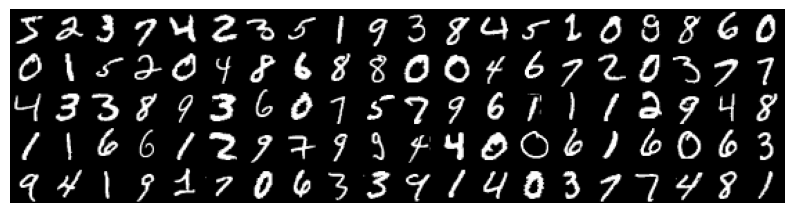

In [5]:
flattened_images = image_palette(X_train, 100)
plt.figure(figsize=(10,20))
plt.imshow(flattened_images)
plt.axis('off')

Train the RBM
-------------
**Exercise** What is the effect of the different parameters: **n_components**, **learning_rate**, **n_iter**. These parameters are, respectively, the number of components, the learning rate and the number of iterations. <br/>
Evaluate the performance visually in the next code cell.


In [107]:
from numpy import ndarray

likelihoods = []
store = Store("rbm_likelihoods.pkl")

class MyBernoulliRBM(BernoulliRBM):
	def __init__(
        self,
        n_components=256,
        *,
        learning_rate=0.1,
        batch_size=10,
        n_iter=10,
        verbose=0,
        random_state=None,
			):
		super(MyBernoulliRBM, self).__init__(
			n_components=n_components,
			learning_rate=learning_rate,
			batch_size=batch_size,
			n_iter=n_iter,
			verbose=verbose,
			random_state=random_state,
		)

	def score_samples(self, X):
		x = super().score_samples(X)
		likelihoods.append(x.mean())
		return x

n, lr, it = 200, 0.1, 30
rbm = MyBernoulliRBM(n_components=n, learning_rate=lr, random_state=10, n_iter=it, verbose=True)
rbm.fit(X_train)

store[(n, lr, it)] = likelihoods

[MyBernoulliRBM] Iteration 1, pseudo-likelihood = -94.08, time = 10.22s
[MyBernoulliRBM] Iteration 2, pseudo-likelihood = -92.81, time = 10.65s
[MyBernoulliRBM] Iteration 3, pseudo-likelihood = -91.55, time = 10.48s
[MyBernoulliRBM] Iteration 4, pseudo-likelihood = -91.28, time = 10.69s
[MyBernoulliRBM] Iteration 5, pseudo-likelihood = -87.88, time = 10.70s
[MyBernoulliRBM] Iteration 6, pseudo-likelihood = -87.15, time = 10.44s
[MyBernoulliRBM] Iteration 7, pseudo-likelihood = -87.36, time = 10.48s
[MyBernoulliRBM] Iteration 8, pseudo-likelihood = -90.72, time = 10.75s
[MyBernoulliRBM] Iteration 9, pseudo-likelihood = -89.61, time = 10.75s
[MyBernoulliRBM] Iteration 10, pseudo-likelihood = -87.77, time = 10.74s
[MyBernoulliRBM] Iteration 11, pseudo-likelihood = -89.26, time = 10.69s
[MyBernoulliRBM] Iteration 12, pseudo-likelihood = -86.96, time = 10.65s
[MyBernoulliRBM] Iteration 13, pseudo-likelihood = -86.26, time = 10.58s
[MyBernoulliRBM] Iteration 14, pseudo-likelihood = -87.08, t

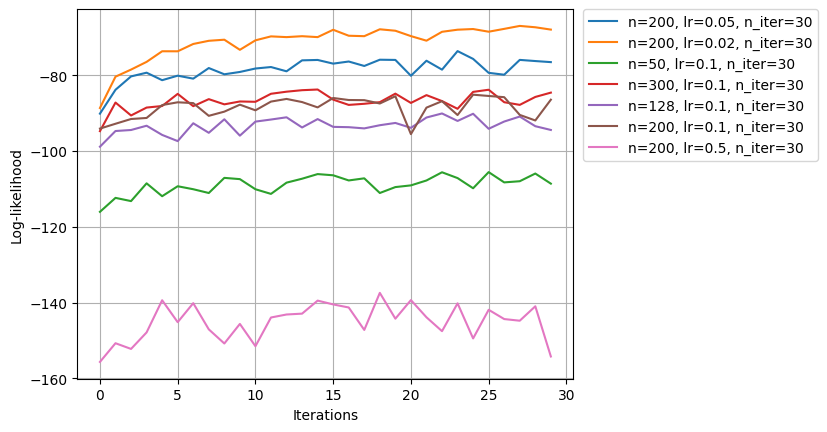

In [109]:
# Plot the likelihoods
plt.figure()
for key, value in store.items():
	plt.plot(value, label=f"n={key[0]}, lr={key[1]}, n_iter={key[2]}")
plt.xlabel("Iterations")
plt.ylabel("Log-likelihood")
plt.grid()
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(FIGURE_PATH / "ex4_1_rbm_likelihoods.pdf", bbox_inches='tight')
plt.show()

Sample the Trained RBM and Show the Results
-------------------------------------------
The gibbs_steps variable determines how many Gibbs sampling steps will be performed for each test image i.e. with the test images as initialization. <br/>
**Exercise** Try different values and observe the result. Can you explain the result? <br/>
Compare the result with the original test images, shown one cell lower.


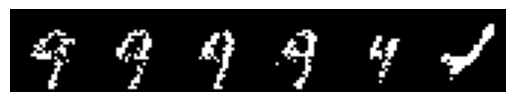

In [110]:
rbm2 = copy.deepcopy(rbm)
image_index = 12
img = X_test.copy()[image_index]
gibbs_steps = [1, 2, 5, 10, 100, 1000]
result_imgs = []
for i in range(gibbs_steps[-1] + 1):
  if i in gibbs_steps:
    result_imgs.append(np.copy(img))
  img = rbm2.gibbs(img)

plt.figure()
plt.imshow(image_palette(np.asarray(result_imgs), m=len(gibbs_steps)))
plt.axis('off')
# plt.savefig(FIGURE_PATH / "ex4_1_rbm_gibbs_steps.pdf", bbox_inches='tight')
plt.show()

(-0.5, 559.5, 139.5, -0.5)

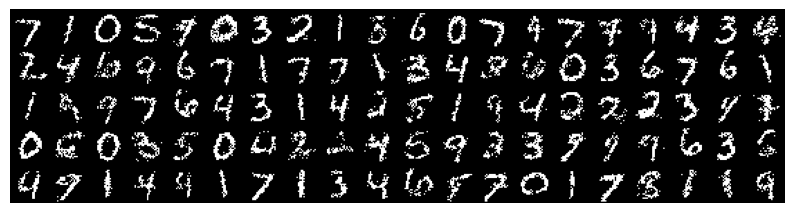

In [112]:
rbm2 = copy.deepcopy(rbm)
gibbs_steps = 1
a = X_test.copy()
for i in range(a.shape[0]):
  for j in range(gibbs_steps):
    a[i] = rbm2.gibbs(a[i])
plt.figure(figsize=(10,20))
plt.imshow(image_palette(a))
plt.axis('off')

(-0.5, 559.5, 139.5, -0.5)

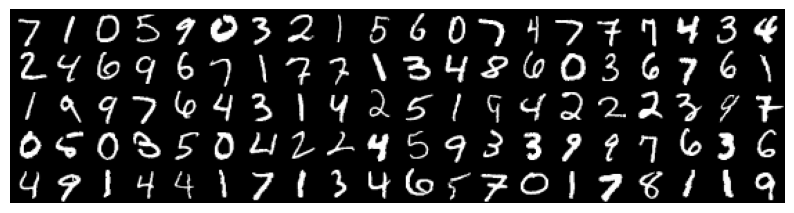

In [59]:
plt.figure(figsize=(10,20))
plt.imshow(image_palette(X_test))
plt.axis('off')

## Reconstruction of Unseen Images
In this cell, we will remove pixel rows from certain images. Using the recently trained RBM, we will then try to reconstruct the original images.  <br/>
The following variables control this process: <br/>


*   **reconstruction_gibbs_steps**: The number of gibbs steps used to reconstruct the image.
*   **start_test_index**: The first index of the test set to use.
*   **nr**: the number of images starting from **start_test_index** to reconstruct.
*   **start_row_to_remove**:  The index of the first row that should be removed.
*   **end_row_to_remove**: The index up to which the rows should be removed.

**Exercise** Adjust these variables and observe the result of the reconstruction in the shown image.
What is the role of the previously seen RBM hyperparameters on the reconstruction? <br/>
How many rows can you remove such that reconstruction is still possible? <br/>
In the next code cell, the removed rows will be replaced by the reconstructed rows.




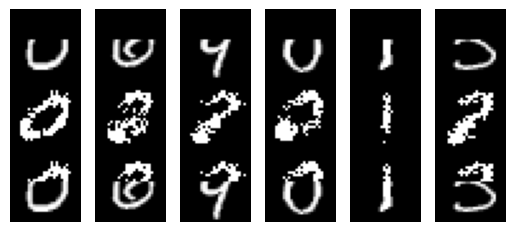

In [103]:
rbm3 = copy.deepcopy(rbm)
reconstruction_gibbs_steps = 10
start_test_index = 10
nr = 6
start_row_to_remove = 0
end_row_to_remove = 12
to_reconstruct = X_test[start_test_index:start_test_index + nr].reshape((-1,28,28))
to_reconstruct = remove_rows(to_reconstruct, start_row_to_remove, end_row_to_remove)
reconstructed = np.zeros(to_reconstruct.shape)
for i in range(nr):
  reconstructed[i] = rbm_gibbs_sample_image(rbm3, to_reconstruct[i], reconstruction_gibbs_steps).reshape((28,28))
  
rec_combined = np.copy(to_reconstruct)
rec_combined[:,start_row_to_remove:end_row_to_remove] = reconstructed[:,start_row_to_remove:end_row_to_remove]

combined_images = np.concatenate((to_reconstruct, reconstructed, rec_combined), axis=1)

fig = plt.figure()
for i in range(nr):
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(combined_images[i])
  ax1.axis('off')

# plt.savefig(FIGURE_PATH / "ex4_1_rbm_reconstruction.pdf", bbox_inches='tight')
plt.show()

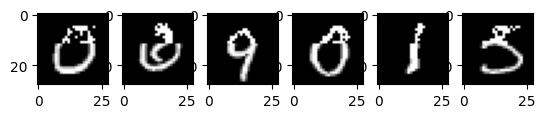

In [67]:
start_row_to_remove
end_row_to_remove
to_reconstruct[:,start_row_to_remove:end_row_to_remove] = reconstructed[:,start_row_to_remove:end_row_to_remove]
fig = plt.figure()
for i in range(nr):
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(to_reconstruct[i])

plt.show()

## Component Visualization
In the final cell, the components (weights of each neuron) of the RBM are shown.<br/>
Observing these components (think back to CNNs) may offer insights into the trained model.

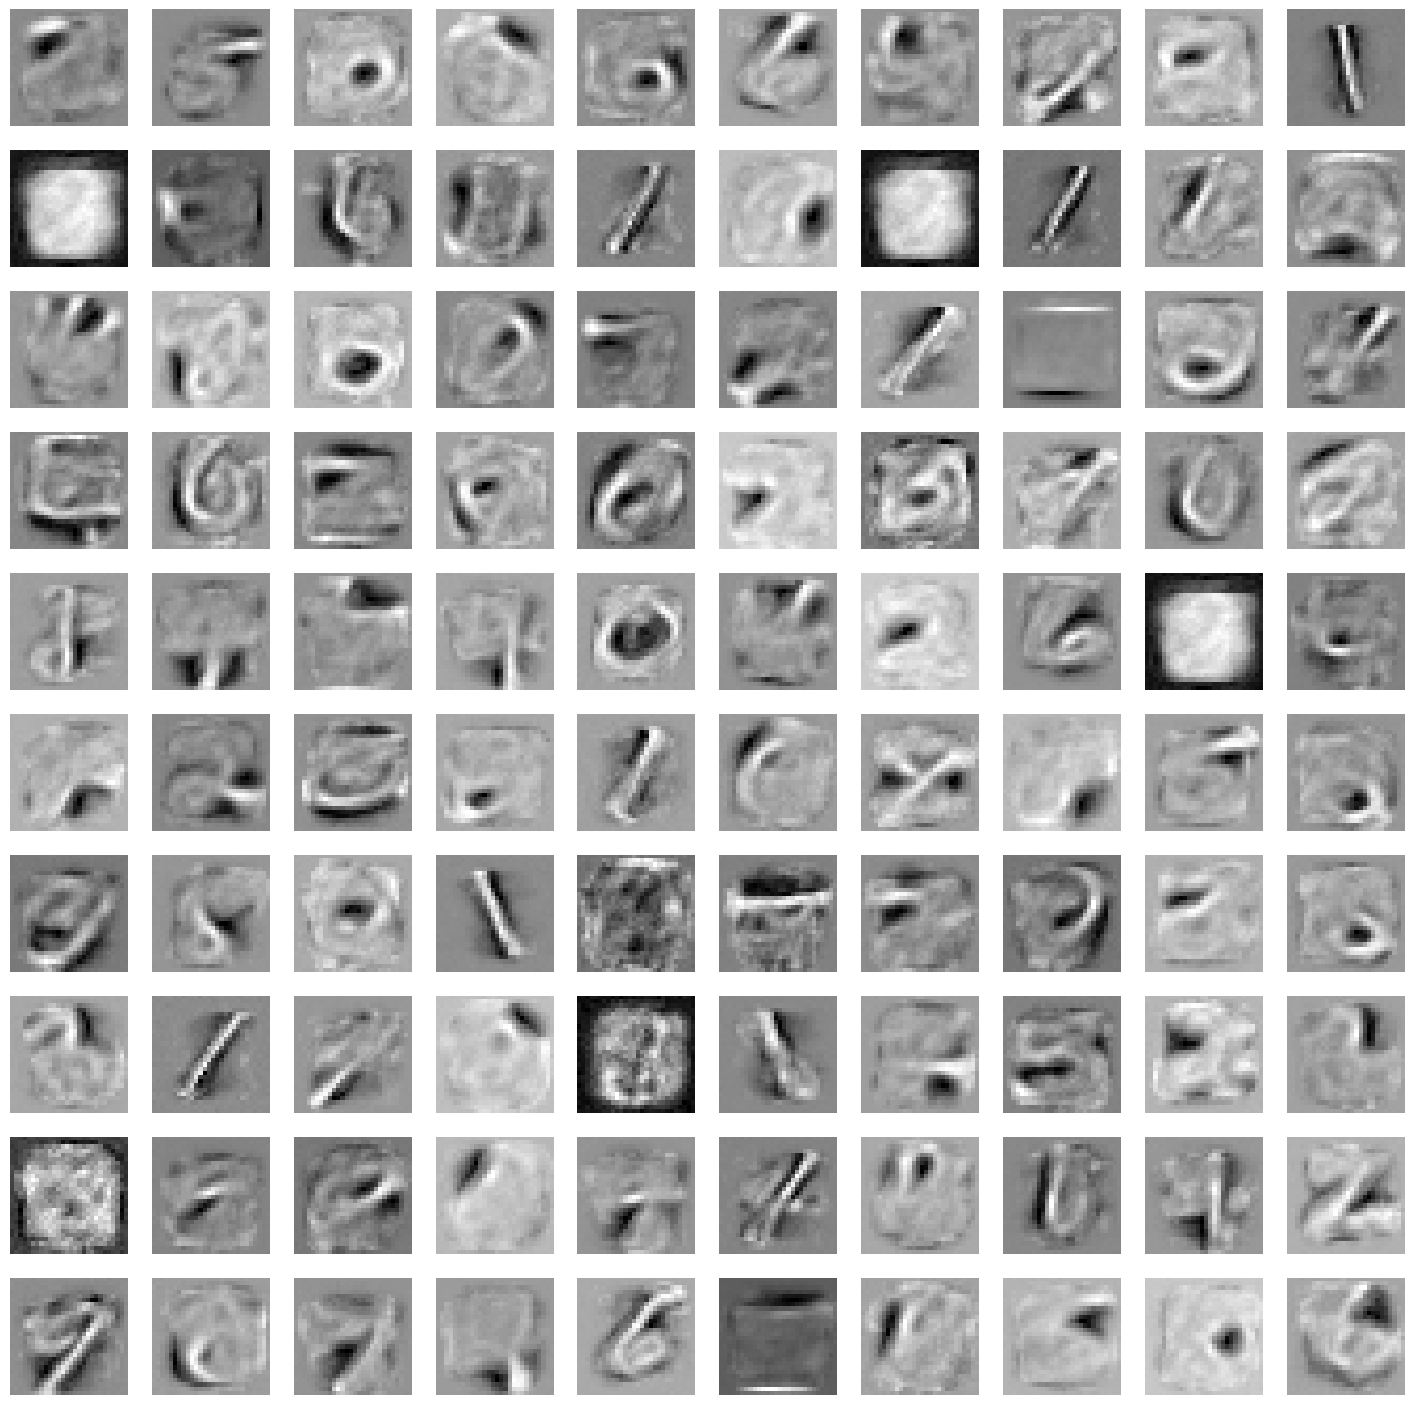

In [118]:
plt.figure(figsize=(18, 18))
nr_components = rbm.components_.shape[0]
nr_components = nr_components if nr_components < 100 else 100
for i in range(nr_components):
	c = rbm.components_[i]
	plt.subplot(10, int(np.ceil(nr_components/10)), i + 1)
	plt.imshow(c.reshape((28, 28)), cmap = "gray", interpolation='nearest')
	plt.axis('off')

# plt.savefig(FIGURE_PATH / "ex4_1_rbm_components.pdf", bbox_inches='tight')
plt.show()
# plt.suptitle('Components extracted by the RBM', fontsize=16)

(100, 784)


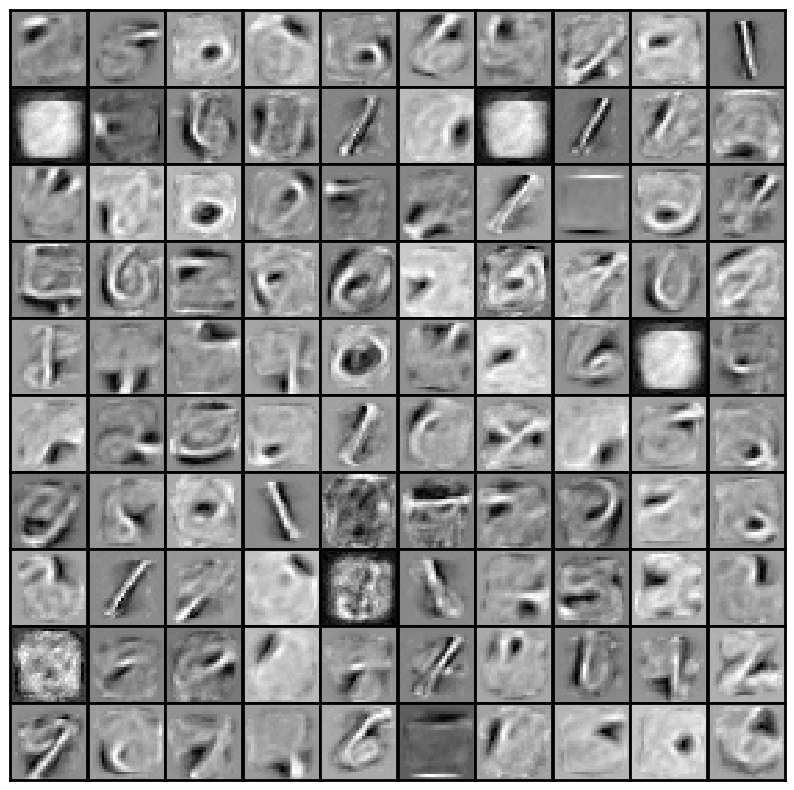

In [119]:
W1_joint = rbm.components_[:100]
print(W1_joint.shape)

fig = plt.figure(figsize=(10, 10))
im_plot(W1_joint, shape=(28, 28), title_params={'fontsize': 20}, imshow_params={'cmap': plt.cm.gray})

plt.savefig(FIGURE_PATH / "ex4_1_rbm_components.pdf", bbox_inches='tight')

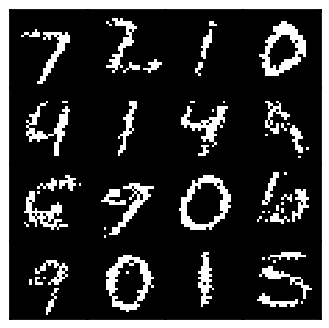

In [122]:
rbm4 = copy.deepcopy(rbm)
V = X_test.copy()
gibbs_steps = 1

for i in range(a.shape[0]):
  for j in range(gibbs_steps):
    V[i] = rbm4.gibbs(V[i])

fig = plt.figure(figsize=(4, 4))
im_plot(V, shape=(28, 28), title='Samples generated by DBM after '+str(gibbs_steps) + ' Gibbs steps',
        imshow_params={'cmap': plt.cm.gray}, n_width=4, n_height=4)
plt.suptitle(None)
plt.savefig(FIGURE_PATH / "ex4_1_rbm_samples.pdf", bbox_inches='tight')